# Temporal GNN Training Visualization

Visualize training progress for temporal heterogeneous GNN models trained on supra-graphs.

In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Add project root to path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except ImportError:
    sns = None
    plt.style.use('ggplot')

# Configure run directory
RUN_DIR = PROJECT_ROOT / 'outputs' / 'gnn_runs' / 'temporal_hetero'
print(f"Loading from: {RUN_DIR}")

Loading from: c:\Users\Dell\projects\multilayer_milp_gnn\benchmark\outputs\gnn_runs\temporal_hetero


## Load Training History

In [2]:
# Load training history
history_path = RUN_DIR / 'training_history.json'

if not history_path.exists():
    print(f"❌ Training history not found at {history_path}")
    print("\nRun training first:")
    print("  python -m src.gnn.train_temporal_hetero --epochs 50")
    history_df = None
else:
    with open(history_path) as f:
        history = json.load(f)
    
    history_df = pd.DataFrame(history)
    print(f"✓ Loaded {len(history_df)} epochs")
    display(history_df.head(10))

✓ Loaded 50 epochs


,epoch,train_loss,val_loss,learning_rate,is_best
0,1,1760.159922,1029.298508,0.001,True
1,2,961.811544,922.368696,0.001,True
2,3,916.120081,889.277632,0.001,True
3,4,874.394481,869.945066,0.001,True
4,5,854.358513,844.313293,0.001,True
5,6,839.286545,849.284990,0.001,False
6,7,832.033033,833.186587,0.001,True
7,8,828.074479,822.674946,0.001,True
8,9,822.872128,831.171604,0.001,False
9,10,819.134219,834.234490,0.001,False


## Training and Validation Loss

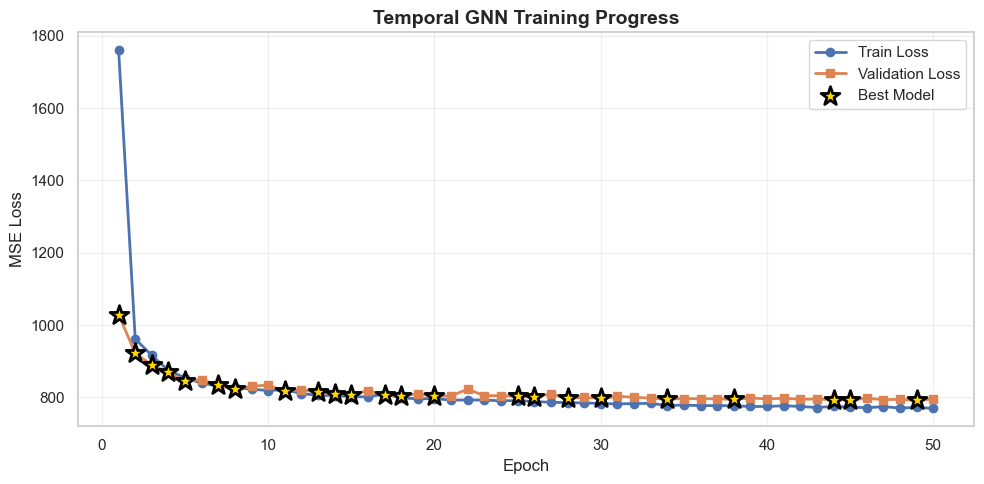


📊 Training Summary:
  Final train loss: 769.912496
  Final val loss:   796.232590
  Best val loss:    791.608218 (epoch 49)


In [3]:
if history_df is not None and not history_df.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(history_df['epoch'], history_df['train_loss'], 
            marker='o', label='Train Loss', linewidth=2)
    ax.plot(history_df['epoch'], history_df['val_loss'], 
            marker='s', label='Validation Loss', linewidth=2)
    
    # Mark best epoch
    if 'is_best' in history_df.columns:
        best_epochs = history_df[history_df['is_best']]
        if not best_epochs.empty:
            ax.scatter(best_epochs['epoch'], best_epochs['val_loss'],
                      s=200, marker='*', color='gold', 
                      edgecolor='black', linewidth=2,
                      label='Best Model', zorder=10)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title('Temporal GNN Training Progress', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Training Summary:")
    print(f"  Final train loss: {history_df['train_loss'].iloc[-1]:.6f}")
    print(f"  Final val loss:   {history_df['val_loss'].iloc[-1]:.6f}")
    print(f"  Best val loss:    {history_df['val_loss'].min():.6f} (epoch {history_df['val_loss'].idxmin() + 1})")
else:
    print("No training history available.")

## Learning Rate Schedule (if available)

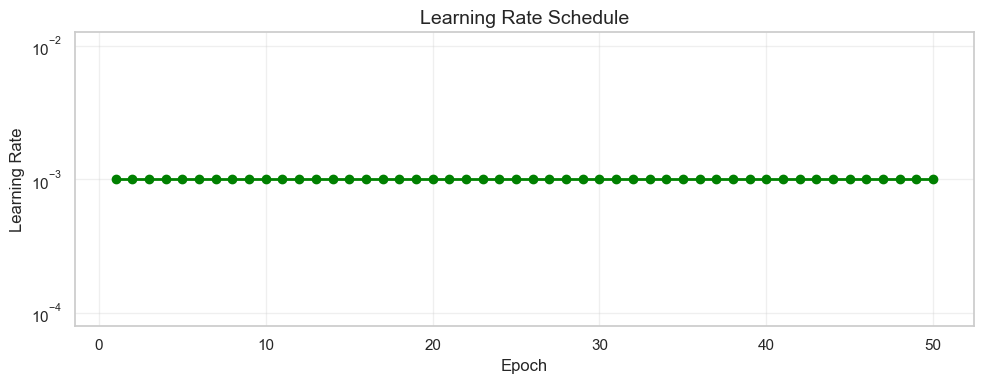

In [4]:
if history_df is not None and 'learning_rate' in history_df.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(history_df['epoch'], history_df['learning_rate'], 
            marker='o', color='green', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)
    ax.set_title('Learning Rate Schedule', fontsize=14)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Learning rate tracking not available.")

## Overfitting Analysis

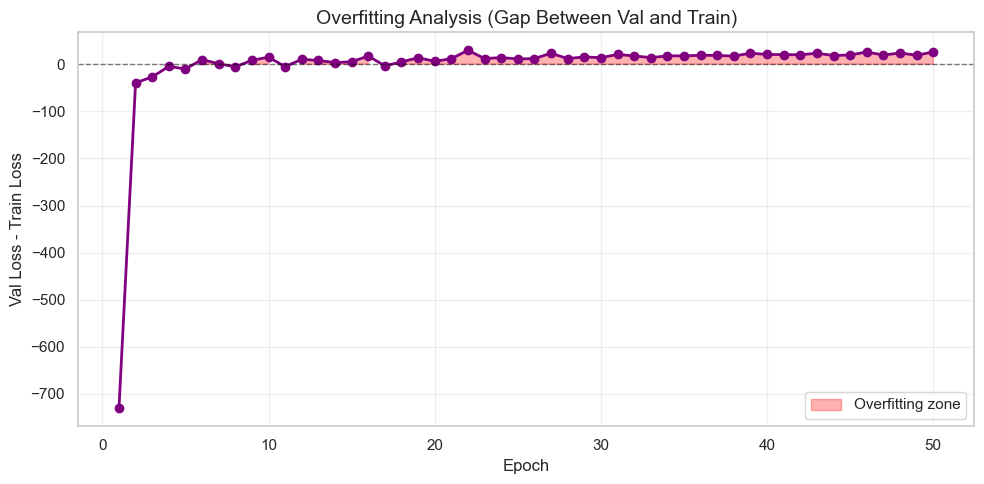

✓ No significant overfitting detected


In [5]:
if history_df is not None and not history_df.empty:
    # Compute train/val gap
    history_df['train_val_gap'] = history_df['val_loss'] - history_df['train_loss']
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history_df['epoch'], history_df['train_val_gap'], 
            marker='o', color='purple', linewidth=2)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.fill_between(history_df['epoch'], 0, history_df['train_val_gap'],
                    where=history_df['train_val_gap'] > 0,
                    alpha=0.3, color='red', label='Overfitting zone')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Val Loss - Train Loss', fontsize=12)
    ax.set_title('Overfitting Analysis (Gap Between Val and Train)', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Check for overfitting
    final_gap = history_df['train_val_gap'].iloc[-1]
    if final_gap > history_df['train_loss'].iloc[-1] * 0.5:
        print("⚠️  Warning: Model may be overfitting (val >> train)")
        print("   Consider: more data, higher dropout, fewer layers")
    else:
        print("✓ No significant overfitting detected")

## Model Configuration

In [7]:
# Load checkpoint info
checkpoint_path = RUN_DIR / 'best_model.pt'

if checkpoint_path.exists():
    import torch
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
    print("📦 Model Checkpoint Info:")
    print(f"  Best epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"  Best val loss: {checkpoint.get('val_loss', 'N/A'):.6f}")
    
    if 'args' in checkpoint:
        args = checkpoint['args']
        print(f"\n🔧 Training Configuration:")
        print(f"  Model type: {args.get('model_type', 'N/A')}")
        print(f"  Hidden dim: {args.get('hidden_dim', 'N/A')}")
        print(f"  Num layers: {args.get('num_layers', 'N/A')}")
        print(f"  Dropout: {args.get('dropout', 'N/A')}")
        print(f"  Learning rate: {args.get('lr', 'N/A')}")
        print(f"  Batch size: {args.get('batch_size', 'N/A')}")
        print(f"  Target vars: {args.get('target_vars', 'N/A')}")
else:
    print("No checkpoint found.")

📦 Model Checkpoint Info:
  Best epoch: 48
  Best val loss: 791.608218

🔧 Training Configuration:
  Model type: rgcn
  Hidden dim: 128
  Num layers: 3
  Dropout: 0.1
  Learning rate: 0.001
  Batch size: 4
  Target vars: thermal,nuclear,solar,wind
